In [2]:
import os
import streamlit as st
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from matplotlib.cm import inferno
import torch
import numpy as np
import caustics
from caustics.utils import get_meshgrid
from app_configs import (
    lens_slider_configs,
    source_slider_configs,
    name_map,
    default_params,
)

from skimage import measure

In [5]:
%%timeit
def caustic_critical_line(
    lens, x, z_s, res, simulation_size, upsample_factor=1, device="cpu"
):
    thx, thy = get_meshgrid(
        res / upsample_factor,
        upsample_factor * simulation_size,
        upsample_factor * simulation_size,
        dtype=torch.float32,
        device=device,
    )
    A = lens.jacobian_lens_equation(thx, thy, z_s, lens.pack(x))
    
    # Compute A's determinant at every point
    detA = torch.linalg.det(A)

    # Generate caustic using skimage's find_contours
    contours = measure.find_contours(detA.cpu().numpy(), 0.0)
    
    x1s = []
    x2s = []
    y1s = []
    y2s = []
    for contour in contours:
        # Convert contour to device tensor
        contour = torch.tensor(contour, device=device)
        # Raytrace the points to the source plane
        x1 = contour[:, 1]# * res / upsample_factor + simulation_size / 2
        x2 = contour[:, 0]# * res / upsample_factor + simulation_size / 2
        y1, y2 = lens.raytrace((x1 - simulation_size / 2) * res, (x2 - simulation_size / 2) * res, z_s, params=lens.pack(x))
        y1s.append(y1.cpu().numpy() / res + simulation_size / 2)
        y2s.append(y2.cpu().numpy() / res + simulation_size / 2)
        x1s.append(x1.cpu().numpy())
        x2s.append(x2.cpu().numpy())

    return x1s, x2s, y1s, y2s

st.set_page_config(layout="wide")
css = """
<style>
    section.main > div {max-width:75rem}
</style>
"""
st.markdown(css, unsafe_allow_html=True)
logo_url = (
    "https://github.com/Ciela-Institute/caustics/raw/main/media/caustics_logo_white.png?raw=true"
)
st.sidebar.image(logo_url)
docs_url = "https://caustics.readthedocs.io/"
st.sidebar.write("Check out the [documentation](%s)!" % docs_url)

lens_menu = st.sidebar.multiselect(
    "Select your Lens(es)", lens_slider_configs.keys(), default=["EPL", "Shear"]
)
source_menu = st.sidebar.radio("Select your Source (more to come)", source_slider_configs.keys())
caustic_trace = st.sidebar.toggle("Trace the caustic", value = True)
critical_curve_trace = st.sidebar.toggle("Trace the critical curve", value = True)


st.sidebar.write("Get it for yourself: pip install caustics")

st.title("Caustics Gravitational Lensing Simulator")
st.header(f"{'+'.join(lens_menu)} and {source_menu} Source")
simulation_size = st.number_input(
    "Simulation resolution", min_value=32, value=256 if source_menu == "Pixelated" else 64
)
fov = 6.5
deltam = fov / simulation_size
# Create a two-column layout
col1, col2, col3 = st.columns([4, 4, 5])

# Sliders for lens parameters in the first column
with col1:
    st.header(r"$\textsf{\tiny Lens Parameters}$", divider="blue")
    # z_lens = st.slider("Lens redshift", min_value=0.0, max_value=10.0, step=0.01)
    x_lens = []
    for lens in lens_menu:
        for param, label, bounds in lens_slider_configs[lens]:
            x_lens.append(
                st.slider(label, min_value=bounds[0], max_value=bounds[1], value=bounds[2])
            )

    x_lens = torch.tensor(x_lens)

with col2:
    st.header(r"$\textsf{\tiny Source Parameters}$", divider="blue")
    # z_source = st.slider("Source redshift", min_value=z_lens, max_value=10.0, step=0.01)
    if source_menu == "Pixelated":
        source_file = st.file_uploader(
            "Upload a source image", type=["png", "jpg"], accept_multiple_files=False
        )
        if source_file is None:
            selfloc = os.path.dirname(os.path.abspath(__file__))
            source_file = os.path.join(selfloc, "logo.png")
        img = plt.imread(source_file)
        source_shape = img.shape[:-1][::-1]
        source_img = torch.tensor(img).permute(2, 0, 1).float()
        if torch.any(source_img > 1).item():
            source_img /= 255.0
        x_source = torch.tensor([])
        src_pixelscale = fov / (max(source_shape))
        fov_scale = st.slider("FOV scale", min_value=0.1, max_value=2.0, value=0.6)
    else:
        x_source = []
        for param, label, bounds in source_slider_configs[source_menu]:
            x_source.append(
                st.slider(label, min_value=bounds[0], max_value=bounds[1], value=bounds[2])
            )
        x_source = torch.tensor(x_source)
x_all = torch.cat((x_lens, x_source))
z_lens = 1.0
z_source = 2.0
cosmology = caustics.FlatLambdaCDM(name="cosmo")
lenses = []
for lens in lens_menu:
    lenses.append(name_map[lens](cosmology, **default_params[lens], z_l=z_lens))
lens = caustics.SinglePlane(lenses=lenses, cosmology=cosmology, z_l=z_lens)
if source_menu == "Pixelated":
    src = list(
        name_map[source_menu](
            name="src",
            image=img,
            pixelscale=src_pixelscale * fov_scale,
            **default_params[source_menu],
        )
        for img in source_img
    )
    minisim = list(
        caustics.Lens_Source(
            lens=lens,
            source=subsrc,
            pixelscale=deltam,
            pixels_x=simulation_size,
            z_s=z_source,
        )
        for subsrc in src
    )
    x1s, x2s, y1s, y2s = caustic_critical_line(
        lens=lens, x=x_lens, z_s=z_source, res=deltam, simulation_size=simulation_size
    )
else:
    src = name_map[source_menu](name="src", **default_params[source_menu])
    minisim = caustics.Lens_Source(
        lens=lens, source=src, pixelscale=deltam, pixels_x=simulation_size, z_s=z_source
    )
    x1s, x2s, y1s, y2s = caustic_critical_line(
        lens=lens, x=x_lens, z_s=z_source, res=deltam, simulation_size=simulation_size
    )


# Plot the caustic trace and lensed image in the second column
with col3:
    st.header(r"$\textsf{\tiny Visualization}$")
    
    if caustic_trace:
        # Plot the unlensed image
        if source_menu == "Pixelated":
            imgs = np.stack(
                [subsim(x_all, lens_source=False).detach().numpy() for subsim in minisim],
                axis=2
            )
            fig2 = px.imshow(imgs)
            if caustic_trace:
                for c in range(len(y1s)):
                    fig2.add_trace(go.Scatter(x=y1s[c], y=y2s[c], mode='lines', line=dict(color='white')))
        else:
            res = minisim(x_all, lens_source=False).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            fig2 = px.imshow(res, color_continuous_scale = 'inferno', origin = "lower")
            if caustic_trace:
                for c in range(len(y1s)):
                    fig2.add_trace(go.Scatter(x=y1s[c], y=y2s[c], mode='lines', line=dict(color='white')))
        fig2.update_layout(
            width=400,  # Adjust as needed
            xaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5),
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5), 3),
                title="Arcseconds from center",
            ),
            yaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5)[1:],
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5)[1:], 3),
                title="Arcseconds from center"
            ),
            coloraxis_showscale=False, 
            margin=dict(l=0, r=0, t=0, b=0),
            showlegend = False,
            coloraxis = dict(cmin = -0.12, cmax = 1)
        )
        fig2.update_yaxes(
            scaleanchor="x",
            scaleratio=1,
          )
        
        st.plotly_chart(fig2)
    else:
        # Plot the unlensed image
        if source_menu == "Pixelated":
            st.image(
                np.stack(
                    [subsim(x_all, lens_source=False).detach().numpy() for subsim in minisim],
                    axis=2
                ),
                caption="Unlensed image",
                use_column_width="always",
                clamp=True,
            )
        else:
            res = minisim(x_all, lens_source=False).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            st.image(
                inferno(res),
                caption="Unlensed image",
                use_column_width="always",
                clamp=True,
            )
    
    if critical_curve_trace:
        if source_menu == "Pixelated":
            imgs = np.stack(
                [subsim(x_all, lens_source=True).detach().numpy() for subsim in minisim],
                axis=2
            )
            fig1 = px.imshow(imgs)
            if critical_curve_trace:
                for c in range(len(x1s)):
                    fig1.add_trace(go.Scatter(x=x1s[c], y=x2s[c], mode='lines', line=dict(color='white')))
        else:
            res = minisim(x_all, lens_source=True).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            fig1 = px.imshow(res, color_continuous_scale = 'inferno', origin = "lower")
            if critical_curve_trace:
                for c in range(len(x1s)):
                    fig1.add_trace(go.Scatter(x=x1s[c], y=x2s[c], mode='lines', line=dict(color='white')))
        fig1.update_layout(
            width=400,  # Adjust as needed
            xaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5),
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5), 3),
                title="Arcseconds from center",
            ),
            yaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5)[1:],
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5)[1:], 3),
                title="Arcseconds from center"
            ),
            coloraxis_showscale=False, 
            margin=dict(l=0, r=0, t=0, b=0),
            showlegend = False,
            coloraxis = dict(cmin = -0.12, cmax = 1)
        )
        fig1.update_yaxes(
            scaleanchor="x",
            scaleratio=1
          )
        st.plotly_chart(fig1)
    else:
        if source_menu == "Pixelated":
            st.image(
                np.stack(
                    [subsim(x_all, lens_source=True).detach().numpy() for subsim in minisim],
                    axis=2
                ),
                caption="Lensed image",
                use_column_width="always",
                clamp=True,
            )
        else:
            res = minisim(x_all, lens_source=True).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            st.image(
                inferno(res),
                caption="Lensed image",
                use_column_width="always",
                clamp=True,
            )

64.6 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
%%timeit
def caustic_critical_line(
    lens, x, z_s, res, simulation_size, upsample_factor=1, device="cpu"
):
    thx, thy = get_meshgrid(
        res / upsample_factor,
        upsample_factor * simulation_size,
        upsample_factor * simulation_size,
        dtype=torch.float32,
        device=device,
    )
    A = lens.jacobian_lens_equation(thx, thy, z_s, lens.pack(x))
    
    # Compute A's determinant at every point
    detA = torch.linalg.det(A)

    # Generate caustic using skimage's find_contours
    contours = measure.find_contours(detA.cpu().numpy(), 0.0)
    
    x1s = []
    x2s = []
    y1s = []
    y2s = []
    for contour in contours:
        # Convert contour to device tensor
        contour = torch.tensor(contour, device=device)
        # Raytrace the points to the source plane
        x1 = contour[:, 1]# * res / upsample_factor + simulation_size / 2
        x2 = contour[:, 0]# * res / upsample_factor + simulation_size / 2
        y1, y2 = lens.raytrace((x1 - simulation_size / 2) * res, (x2 - simulation_size / 2) * res, z_s, params=lens.pack(x))
        y1s.append(y1.cpu().numpy() / res + simulation_size / 2)
        y2s.append(y2.cpu().numpy() / res + simulation_size / 2)
        x1s.append(x1.cpu().numpy())
        x2s.append(x2.cpu().numpy())

    return x1s, x2s, y1s, y2s

st.set_page_config(layout="wide")
css = """
<style>
    section.main > div {max-width:75rem}
</style>
"""
st.markdown(css, unsafe_allow_html=True)
logo_url = (
    "https://github.com/Ciela-Institute/caustics/raw/main/media/caustics_logo_white.png?raw=true"
)
st.sidebar.image(logo_url)
docs_url = "https://caustics.readthedocs.io/"
st.sidebar.write("Check out the [documentation](%s)!" % docs_url)

lens_menu = st.sidebar.multiselect(
    "Select your Lens(es)", lens_slider_configs.keys(), default=["EPL", "Shear"]
)
source_menu = st.sidebar.radio("Select your Source (more to come)", source_slider_configs.keys())
caustic_trace = st.sidebar.toggle("Trace the caustic", value = True)
critical_curve_trace = st.sidebar.toggle("Trace the critical curve", value = True)


st.sidebar.write("Get it for yourself: pip install caustics")

st.title("Caustics Gravitational Lensing Simulator")
st.header(f"{'+'.join(lens_menu)} and {source_menu} Source")
simulation_size = st.number_input(
    "Simulation resolution", min_value=32, value=256 if source_menu == "Pixelated" else 64
)
fov = 6.5
deltam = fov / simulation_size
# Create a two-column layout
col1, col2, col3 = st.columns([4, 4, 5])

# Sliders for lens parameters in the first column
with col1:
    st.header(r"$\textsf{\tiny Lens Parameters}$", divider="blue")
    # z_lens = st.slider("Lens redshift", min_value=0.0, max_value=10.0, step=0.01)
    x_lens = []
    for lens in lens_menu:
        for param, label, bounds in lens_slider_configs[lens]:
            x_lens.append(
                st.slider(label, min_value=bounds[0], max_value=bounds[1], value=bounds[2])
            )

    x_lens = torch.tensor(x_lens)

with col2:
    st.header(r"$\textsf{\tiny Source Parameters}$", divider="blue")
    # z_source = st.slider("Source redshift", min_value=z_lens, max_value=10.0, step=0.01)
    if source_menu == "Pixelated":
        source_file = st.file_uploader(
            "Upload a source image", type=["png", "jpg"], accept_multiple_files=False
        )
        if source_file is None:
            selfloc = os.path.dirname(os.path.abspath(__file__))
            source_file = os.path.join(selfloc, "logo.png")
        img = plt.imread(source_file)
        source_shape = img.shape[:-1][::-1]
        source_img = torch.tensor(img).permute(2, 0, 1).float()
        if torch.any(source_img > 1).item():
            source_img /= 255.0
        x_source = torch.tensor([])
        src_pixelscale = fov / (max(source_shape))
        fov_scale = st.slider("FOV scale", min_value=0.1, max_value=2.0, value=0.6)
    else:
        x_source = []
        for param, label, bounds in source_slider_configs[source_menu]:
            x_source.append(
                st.slider(label, min_value=bounds[0], max_value=bounds[1], value=bounds[2])
            )
        x_source = torch.tensor(x_source)
x_all = torch.cat((x_lens, x_source))
z_lens = 1.0
z_source = 2.0
cosmology = caustics.FlatLambdaCDM(name="cosmo")
lenses = []
for lens in lens_menu:
    lenses.append(name_map[lens](cosmology, **default_params[lens], z_l=z_lens))
lens = caustics.SinglePlane(lenses=lenses, cosmology=cosmology, z_l=z_lens)
if source_menu == "Pixelated":
    src = list(
        name_map[source_menu](
            name="src",
            image=img,
            pixelscale=src_pixelscale * fov_scale,
            **default_params[source_menu],
        )
        for img in source_img
    )
    minisim = list(
        caustics.Lens_Source(
            lens=lens,
            source=subsrc,
            pixelscale=deltam,
            pixels_x=simulation_size,
            z_s=z_source,
        )
        for subsrc in src
    )
    x1s, x2s, y1s, y2s = caustic_critical_line(
        lens=lens, x=x_lens, z_s=z_source, res=deltam, simulation_size=simulation_size
    )
else:
    src = name_map[source_menu](name="src", **default_params[source_menu])
    minisim = caustics.Lens_Source(
        lens=lens, source=src, pixelscale=deltam, pixels_x=simulation_size, z_s=z_source
    )
    x1s, x2s, y1s, y2s = caustic_critical_line(
        lens=lens, x=x_lens, z_s=z_source, res=deltam, simulation_size=simulation_size
    )


# Plot the caustic trace and lensed image in the second column
with col3:
    st.header(r"$\textsf{\tiny Visualization}$")
    
    if caustic_trace:
        # Plot the unlensed image
        if source_menu == "Pixelated":
            imgs = np.stack(
                [subsim(x_all, lens_source=False).detach().numpy() for subsim in minisim],
                axis=2
            )
            fig2 = px.imshow(imgs)
            if caustic_trace:
                for c in range(len(y1s)):
                    fig2.add_trace(go.Scatter(x=y1s[c], y=y2s[c], mode='lines', line=dict(color='white')))
        else:
            res = minisim(x_all, lens_source=False).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            fig2 = px.imshow(res, color_continuous_scale = 'inferno', origin = "lower", binary_string=True)
            if caustic_trace:
                for c in range(len(y1s)):
                    fig2.add_trace(go.Scatter(x=y1s[c], y=y2s[c], mode='lines', line=dict(color='white')))
        fig2.update_layout(
            width=400,  # Adjust as needed
            xaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5),
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5), 3),
                title="Arcseconds from center",
            ),
            yaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5)[1:],
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5)[1:], 3),
                title="Arcseconds from center"
            ),
            coloraxis_showscale=False, 
            margin=dict(l=0, r=0, t=0, b=0),
            showlegend = False,
            coloraxis = dict(cmin = -0.12, cmax = 1)
        )
        fig2.update_yaxes(
            scaleanchor="x",
            scaleratio=1,
          )
        
        st.plotly_chart(fig2)
    else:
        # Plot the unlensed image
        if source_menu == "Pixelated":
            st.image(
                np.stack(
                    [subsim(x_all, lens_source=False).detach().numpy() for subsim in minisim],
                    axis=2
                ),
                caption="Unlensed image",
                use_column_width="always",
                clamp=True,
            )
        else:
            res = minisim(x_all, lens_source=False).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            st.image(
                inferno(res),
                caption="Unlensed image",
                use_column_width="always",
                clamp=True,
            )
    
    if critical_curve_trace:
        if source_menu == "Pixelated":
            imgs = np.stack(
                [subsim(x_all, lens_source=True).detach().numpy() for subsim in minisim],
                axis=2
            )
            fig1 = px.imshow(imgs)
            if critical_curve_trace:
                for c in range(len(x1s)):
                    fig1.add_trace(go.Scatter(x=x1s[c], y=x2s[c], mode='lines', line=dict(color='white')))
        else:
            res = minisim(x_all, lens_source=True).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            fig1 = px.imshow(res, color_continuous_scale = 'inferno', origin = "lower", binary_string=True)
            if critical_curve_trace:
                for c in range(len(x1s)):
                    fig1.add_trace(go.Scatter(x=x1s[c], y=x2s[c], mode='lines', line=dict(color='white')))
        fig1.update_layout(
            width=400,  # Adjust as needed
            xaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5),
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5), 3),
                title="Arcseconds from center",
            ),
            yaxis=dict(
                tickvals=np.linspace(0, simulation_size, 5)[1:],
                ticktext=np.round(np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5)[1:], 3),
                title="Arcseconds from center"
            ),
            coloraxis_showscale=False, 
            margin=dict(l=0, r=0, t=0, b=0),
            showlegend = False,
            coloraxis = dict(cmin = -0.12, cmax = 1)
        )
        fig1.update_yaxes(
            scaleanchor="x",
            scaleratio=1
          )
        st.plotly_chart(fig1)
    else:
        if source_menu == "Pixelated":
            st.image(
                np.stack(
                    [subsim(x_all, lens_source=True).detach().numpy() for subsim in minisim],
                    axis=2
                ),
                caption="Lensed image",
                use_column_width="always",
                clamp=True,
            )
        else:
            res = minisim(x_all, lens_source=True).numpy()
            res = (res - np.min(res)) / (np.max(res) - np.min(res))
            st.image(
                inferno(res),
                caption="Lensed image",
                use_column_width="always",
                clamp=True,
            )

2024-03-13 21:34:31.252 
  command:

    streamlit run /home/misha/main_store/anaconda3/envs/lensing/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


46.5 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


479 ms ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


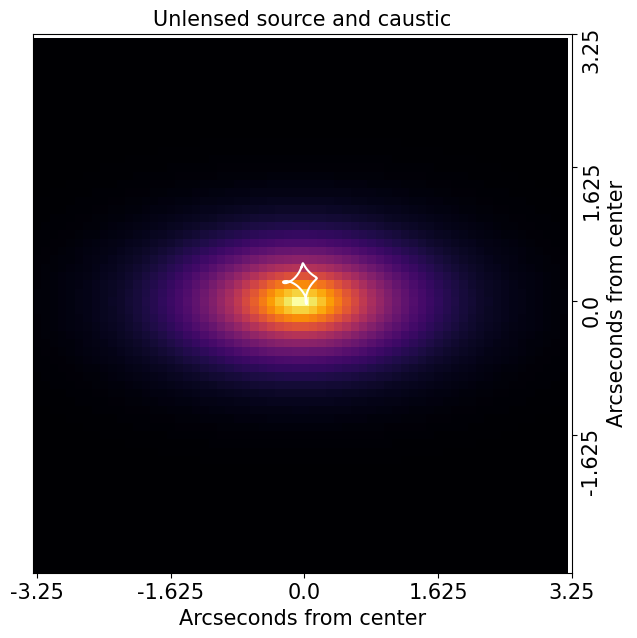

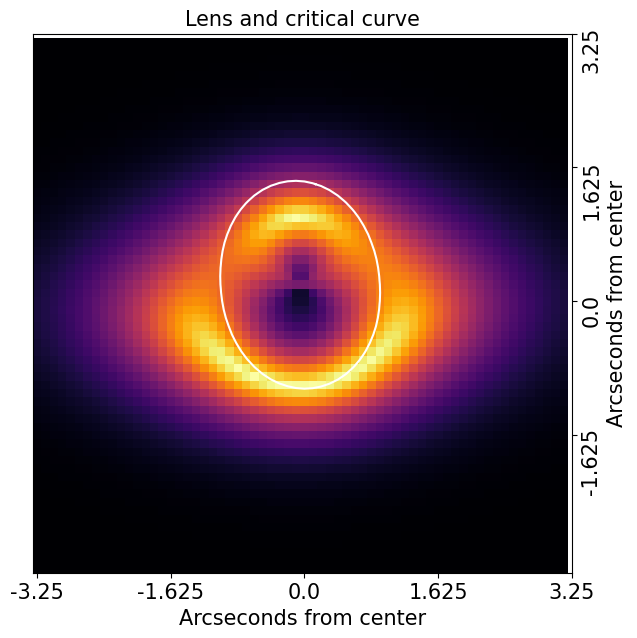

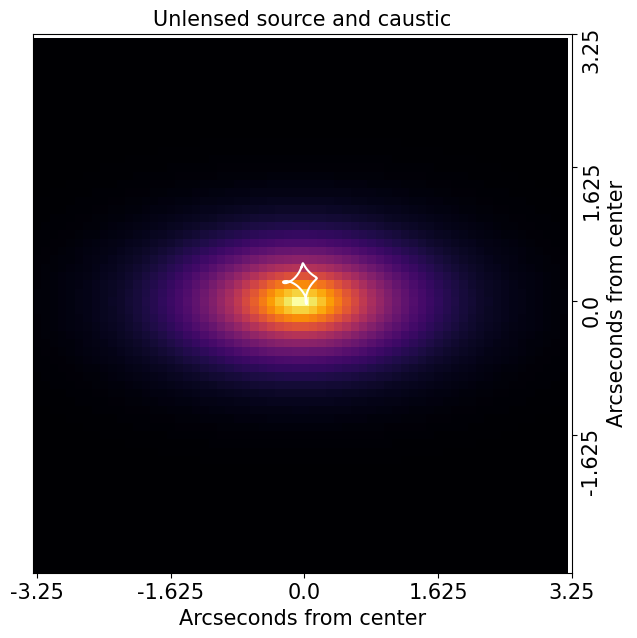

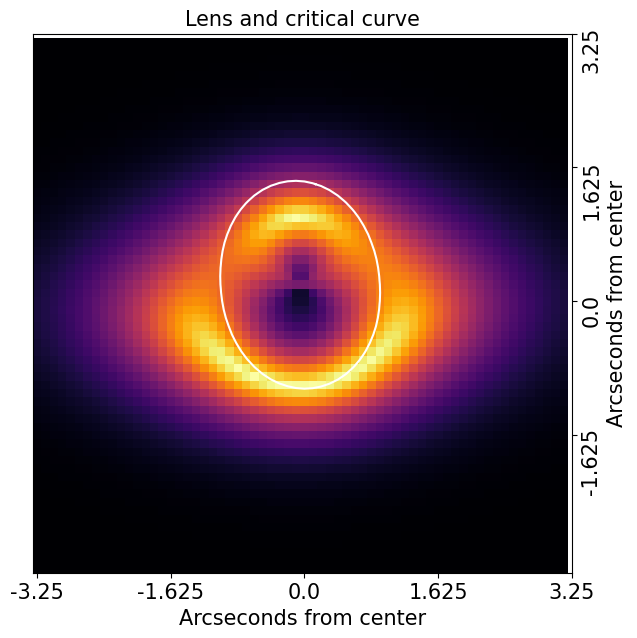

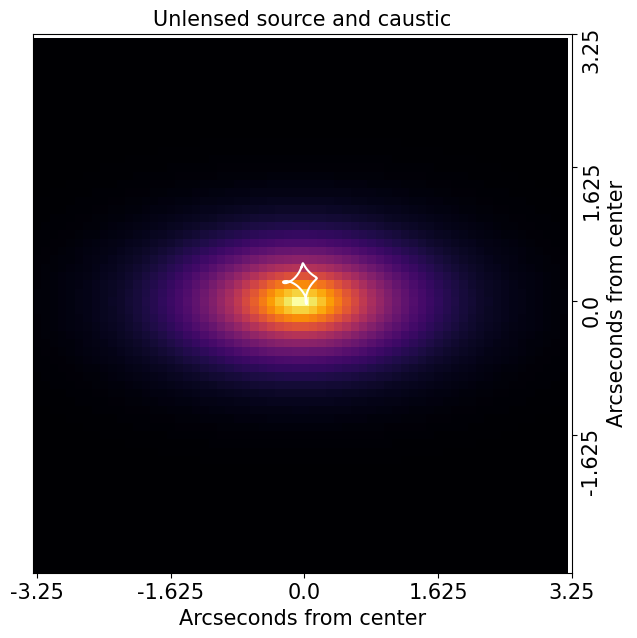

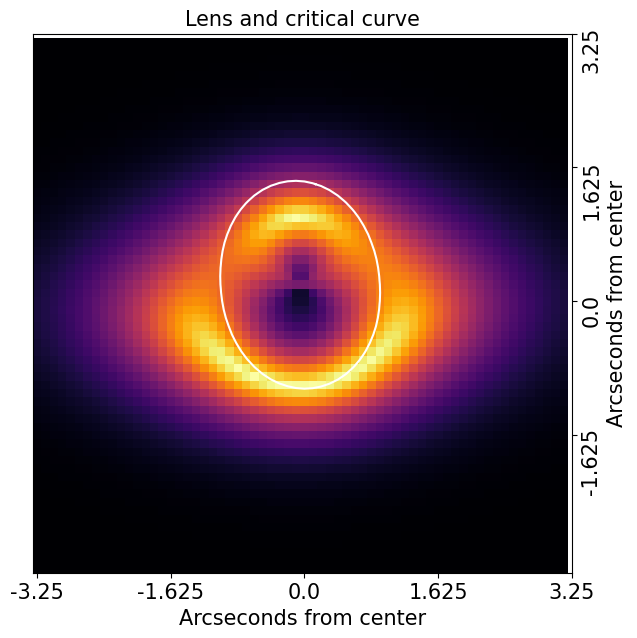

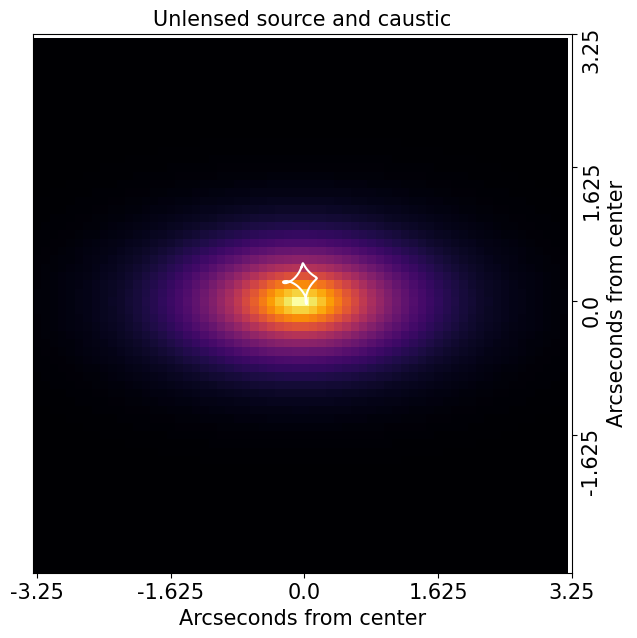

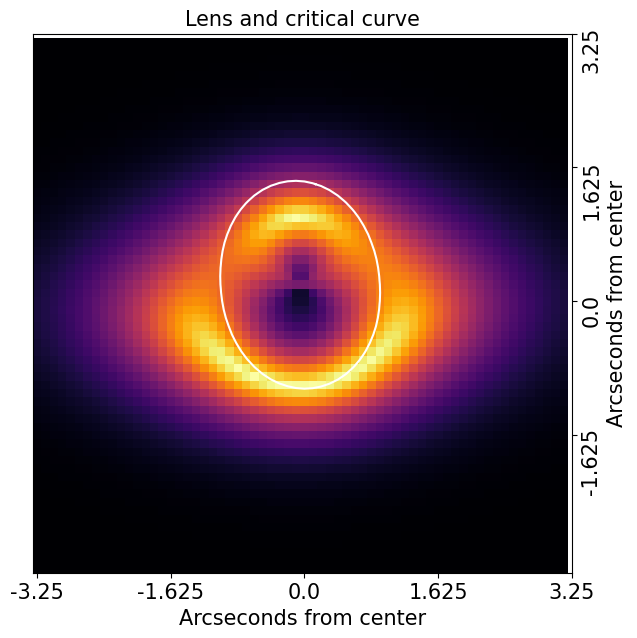

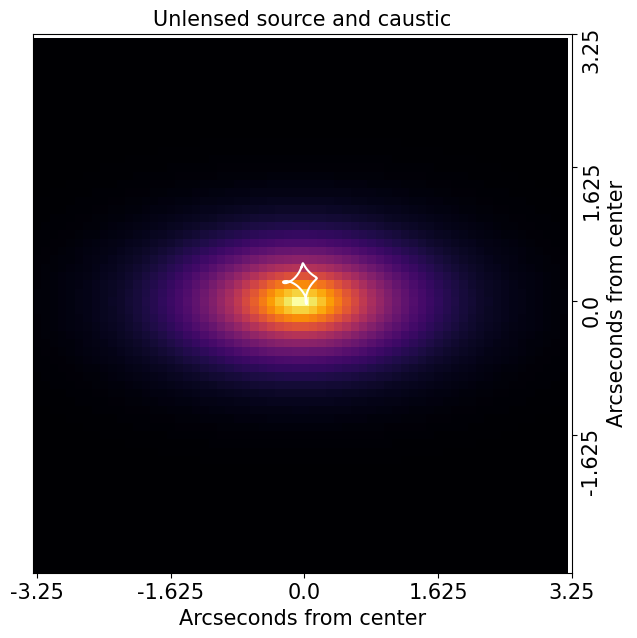

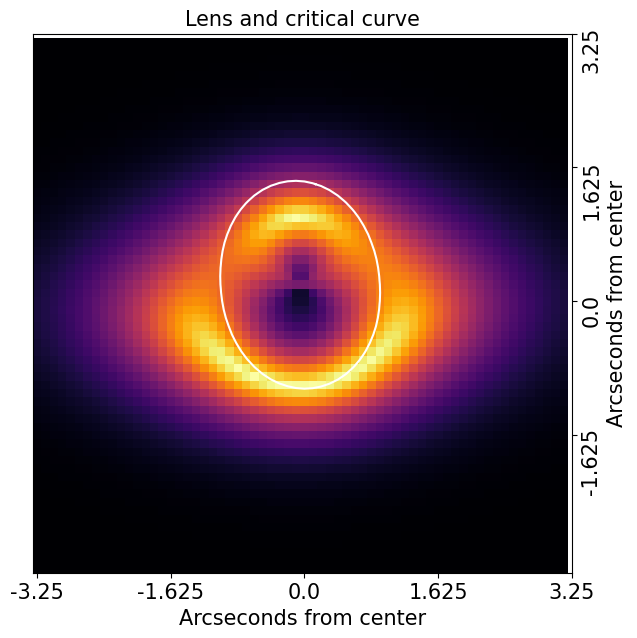

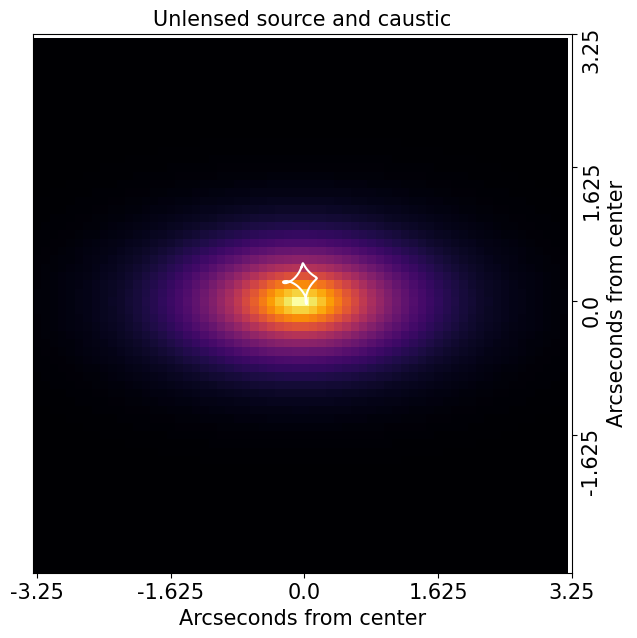

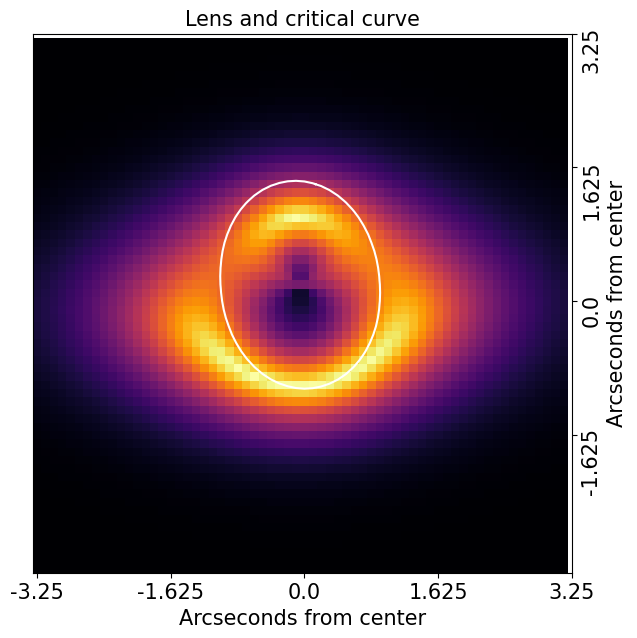

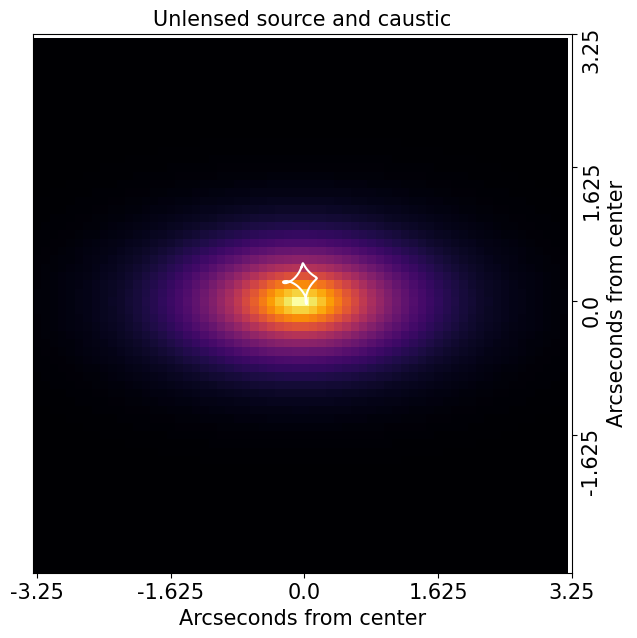

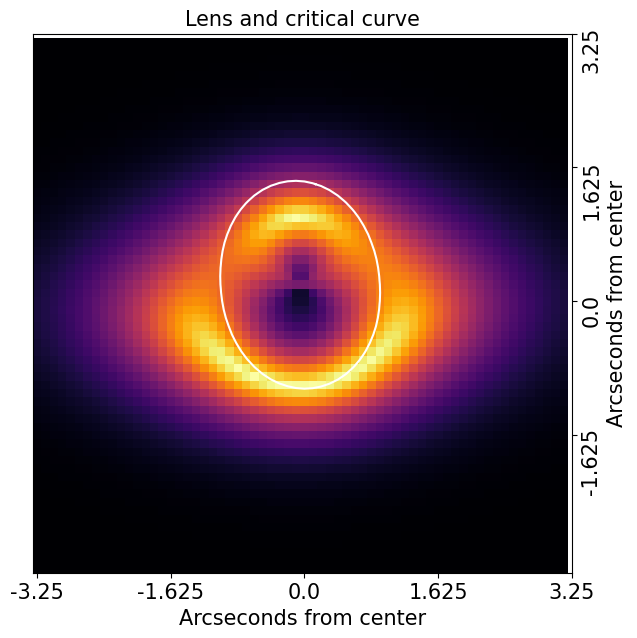

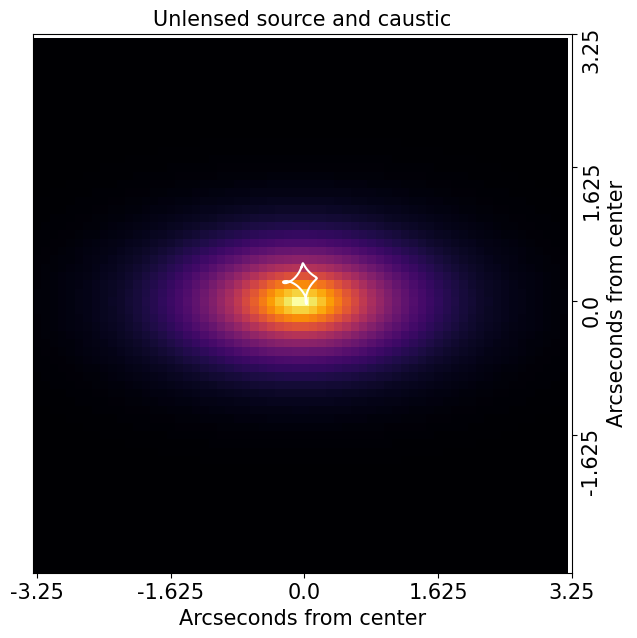

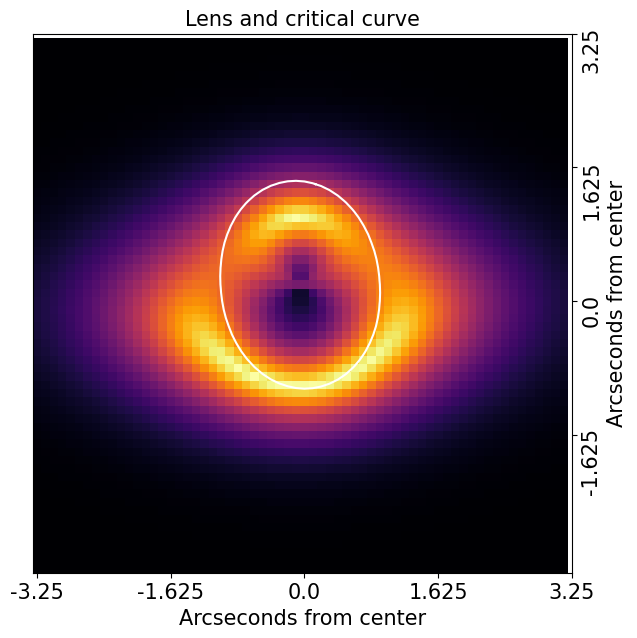

In [4]:
%%timeit

def caustic_critical_line(
    lens, x, z_s, res, simulation_size, upsample_factor=1, device="cpu"
):
    thx, thy = get_meshgrid(
        res / upsample_factor,
        upsample_factor * simulation_size,
        upsample_factor * simulation_size,
        dtype=torch.float32,
        device=device,
    )
    A = lens.jacobian_lens_equation(thx, thy, z_s, lens.pack(x))
    
    # Compute A's determinant at every point
    detA = torch.linalg.det(A)

    # Generate caustic using skimage's find_contours
    contours = measure.find_contours(detA.cpu().numpy(), 0.0)
    
    x1s = []
    x2s = []
    y1s = []
    y2s = []
    for contour in contours:
        # Convert contour to device tensor
        contour = torch.tensor(contour, device=device)
        # Raytrace the points to the source plane
        x1 = contour[:, 1]# * res / upsample_factor + simulation_size / 2
        x2 = contour[:, 0]# * res / upsample_factor + simulation_size / 2
        y1, y2 = lens.raytrace((x1 - simulation_size / 2) * res, (x2 - simulation_size / 2) * res, z_s, params=lens.pack(x))
        y1s.append(y1.cpu().numpy() / res + simulation_size / 2)
        y2s.append(y2.cpu().numpy() / res + simulation_size / 2)
        x1s.append(x1.cpu().numpy())
        x2s.append(x2.cpu().numpy())

    return x1s, x2s, y1s, y2s

st.set_page_config(layout="wide")
css = """
<style>
    section.main > div {max-width:75rem}
</style>
"""
st.markdown(css, unsafe_allow_html=True)
logo_url = (
    "https://github.com/Ciela-Institute/caustics/raw/main/media/caustics_logo_white.png?raw=true"
)
st.sidebar.image(logo_url)
docs_url = "https://caustics.readthedocs.io/"
st.sidebar.write("Check out the [documentation](%s)!" % docs_url)

lens_menu = st.sidebar.multiselect(
    "Select your Lens(es)", lens_slider_configs.keys(), default=["EPL", "Shear"]
)
source_menu = st.sidebar.radio("Select your Source (more to come)", source_slider_configs.keys())
caustic_trace = st.sidebar.toggle("Trace the caustic", value = True)
critical_curve_trace = st.sidebar.toggle("Trace the critical curve", value = True)


st.sidebar.write("Get it for yourself: pip install caustics")

st.title("Caustics Gravitational Lensing Simulator")
st.header(f"{'+'.join(lens_menu)} and {source_menu} Source")
simulation_size = st.number_input(
    "Simulation resolution", min_value=32, value=256 if source_menu == "Pixelated" else 64
)
fov = 6.5
deltam = fov / simulation_size
# Create a two-column layout
col1, col2, col3 = st.columns([4, 4, 5])

# Sliders for lens parameters in the first column
with col1:
    st.header(r"$\textsf{\tiny Lens Parameters}$", divider="blue")
    # z_lens = st.slider("Lens redshift", min_value=0.0, max_value=10.0, step=0.01)
    x_lens = []
    for lens in lens_menu:
        for param, label, bounds in lens_slider_configs[lens]:
            x_lens.append(
                st.slider(label, min_value=bounds[0], max_value=bounds[1], value=bounds[2])
            )

    x_lens = torch.tensor(x_lens)

with col2:
    st.header(r"$\textsf{\tiny Source Parameters}$", divider="blue")
    # z_source = st.slider("Source redshift", min_value=z_lens, max_value=10.0, step=0.01)
    if source_menu == "Pixelated":
        source_file = st.file_uploader(
            "Upload a source image", type=["png", "jpg"], accept_multiple_files=False
        )
        if source_file is None:
            selfloc = os.path.dirname(os.path.abspath(__file__))
            source_file = os.path.join(selfloc, "logo.png")
        img = plt.imread(source_file)
        source_shape = img.shape[:-1][::-1]
        source_img = torch.tensor(img).permute(2, 0, 1).float()
        if torch.any(source_img > 1).item():
            source_img /= 255.0
        x_source = torch.tensor([])
        src_pixelscale = fov / (max(source_shape))
        fov_scale = st.slider("FOV scale", min_value=0.1, max_value=2.0, value=0.6)
    else:
        x_source = []
        for param, label, bounds in source_slider_configs[source_menu]:
            x_source.append(
                st.slider(label, min_value=bounds[0], max_value=bounds[1], value=bounds[2])
            )
        x_source = torch.tensor(x_source)
x_all = torch.cat((x_lens, x_source))
z_lens = 1.0
z_source = 2.0
cosmology = caustics.FlatLambdaCDM(name="cosmo")
lenses = []
for lens in lens_menu:
    lenses.append(name_map[lens](cosmology, **default_params[lens], z_l=z_lens))
lens = caustics.SinglePlane(lenses=lenses, cosmology=cosmology, z_l=z_lens)
if source_menu == "Pixelated":
    src = list(
        name_map[source_menu](
            name="src",
            image=img,
            pixelscale=src_pixelscale * fov_scale,
            **default_params[source_menu],
        )
        for img in source_img
    )
    minisim = list(
        caustics.Lens_Source(
            lens=lens,
            source=subsrc,
            pixelscale=deltam,
            pixels_x=simulation_size,
            z_s=z_source,
        )
        for subsrc in src
    )
    x1s, x2s, y1s, y2s = caustic_critical_line(
        lens=lens, x=x_lens, z_s=z_source, res=deltam, simulation_size=simulation_size
    )
else:
    src = name_map[source_menu](name="src", **default_params[source_menu])
    minisim = caustics.Lens_Source(
        lens=lens, source=src, pixelscale=deltam, pixels_x=simulation_size, z_s=z_source
    )
    x1s, x2s, y1s, y2s = caustic_critical_line(
        lens=lens, x=x_lens, z_s=z_source, res=deltam, simulation_size=simulation_size
    )


# Plot the caustic trace and lensed image in the second column
with col3:
    st.header(r"$\textsf{\tiny Visualization}$", divider="blue")

    # Plot the unlensed image
    fig2, ax2 = plt.subplots(figsize=(7, 7))
    ax2.set_title("Unlensed source and caustic", fontsize=15)
    if source_menu == "Pixelated":
        ax2.imshow(
            np.stack(
                list(
                    subsim(x_all, lens_source=False).detach().numpy()
                    for subsim in minisim
                ),
                axis=2,
            ),
        )
        if caustic_trace:
            for c in range(len(y1s)):
                ax2.plot(y1s[c], y2s[c], "-w")
    else:
        ax2.imshow(
            minisim(x_all, lens_source=False),
            origin="lower",
            cmap="inferno",
        )
        if caustic_trace:
            for c in range(len(y1s)):
                ax2.plot(y1s[c], y2s[c], "-w")
    ax2.set_xticks(
        ticks=np.linspace(0, simulation_size, 5).astype(int),
        labels=np.round(
            np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5),
            3,
        ),
        fontsize=15,
    )
    ax2.set_xlabel("Arcseconds from center", fontsize=15)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.set_yticks(
        ticks=np.linspace(0, simulation_size, 5).astype(int)[1:],
        labels=np.round(
            np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5),
            3,
        )[1:],
        fontsize=15,
        rotation=90,
    )
    ax2.set_ylabel("Arcseconds from center", fontsize=15)
    st.pyplot(fig2)
    
    fig1, ax1 = plt.subplots(figsize=(7, 7))
    ax1.set_title("Lens and critical curve", fontsize=15)
    if source_menu == "Pixelated":
        ax1.imshow(
            np.stack(
                list(
                    subsim(x_all, lens_source=True).detach().numpy()
                    for subsim in minisim
                ),
                axis=2,
            ),
        )
        if critical_curve_trace:
            for c in range(len(x1s)):
                ax1.plot(x1s[c], x2s[c], "-w")
    else:
        ax1.imshow(
            minisim(x_all, lens_source=True),
            origin="lower",
            cmap="inferno",
        )
        if critical_curve_trace:
            for c in range(len(x1s)):
                ax1.plot(x1s[c], x2s[c], "-w")
    ax1.set_xticks(
        ticks=np.linspace(0, simulation_size, 5).astype(int),
        labels=np.round(
            np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5),
            3,
        ),
        fontsize=15,
    )
    ax1.set_xlabel("Arcseconds from center", fontsize=15)
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    ax1.set_yticks(
        ticks=np.linspace(0, simulation_size, 5).astype(int)[1:],
        labels=np.round(
            np.linspace(-simulation_size * deltam / 2, simulation_size * deltam / 2, 5),
            3,
        )[1:],
        fontsize=15,
        rotation=90,
    )
    ax1.set_ylabel("Arcseconds from center", fontsize=15)
    st.pyplot(fig1)